### Author : Si-Dan HO

# Pricing et calibration d'options sur VIX dans un modèle de courbe de variance forward

In [1]:
import time
import datetime as dt
import pandas as pd
import numpy as np
import math
import scipy.stats as sps
import scipy as sp
import scipy.optimize as spop
import matplotlib.pyplot as plt
import os
import scipy.integrate as integrate

import pylab as py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

import random

# Sommaire

- Introduction
- Pricing Monte-Carlo des options vanilles sur VIX sous le modèle de Bergomi
- Valorisation des Futures VIX sous le modèle de Bergomi
    - Application sur des données réelles des Futures VIX et calibration de la courbe de variance $\xi_0^T$
- Calcul de la volatilité implicite des options vanilles sur VIX sous le modèle de Bergomi
    - Formule close de Black Scholes adaptée pour les options vanilles sur VIX
    - Volatilité implicite des Options vanilles sur VIX en utilisant les futures VIX du marché
    - Chargement et traitement des données contenant le prix des options sur VIX
    - Calcul de la volatilité implicite des options sur VIX
    - Comparaison de la volatilité implicite calculée avec celle observée
    - Calcul de la volatilité implicite sous le modèle de Bergomi
    - Traçage de la volatilité implicite
- Pricing d'options sur VIX sous le modèle de Bergomi à deux facteurs
- Valorisation des Futures VIX sous le modèle de Bergomi à deux facteurs
    - Calibration de la courbe de variance forward instantanée initiale $\xi_0^T$ sous le modèle de Bergomi à deux facteurs
- Calcul de la volatilité implicite sous le modèle à deux facteurs de Bergomi
    - Traçage de la volatilité implicite
- Calibration du modèle de Bergomi à deux facteurs

# Introduction

On considère un modèle stochastique pour la variance forward d'un actif S. Pour tout $T > 0$, le processus de variance forward instantanée $(\xi_t^T)_{t < T}$ est solution sous la probabilité risque neutre de l'équation différentielle stochastique de Dupire (1993):

$$
d\xi_t^T =\xi_t^T \varphi (T-t) dW_t, \ t<T
$$

$$
\xi_0^T = \xi_0^{T, mkt}
$$

Avec $W_t$ un mouvement brownien sur l'espace probabilisé d'étude, $\varphi \in L^2_{loc}(\mathbb{R}_{+})$ une fonction de carré intégrable, et $T \rightarrow \xi_0^{T, mkt}$ la courbe de variance forward instantanée initiale donnée par le marché en $t=0$.

On pose $\mathbb{Q}$ la probabilité risque neutre, et considère une option sur variance forward de maturité $T$ et de payoff $\psi (V_T^{T_1, T_2})$, et dont le prix est ainsi égal au temps $t$ à :

$Prix_t(\psi (V_T^{T_1, T_2}),T) = \mathbb{E}^{\mathbb{Q}}[e^{-r(T-t)}\psi (V_T^{T_1, T_2})|F_t]$ avec $V_T^{T_1, T_2} = \frac{1}{T_2 - T_1} \int_{T_1}^{T_2} \xi_T^{u} du$.

On suppose que le taux d'intérêt $r$ est négligeable. La première equation différentielle stochastique permettant d'obtenir la solution explicite :

$$
\xi_t^T = \xi_0^Te^{\int_{0}^{t} \varphi (T-s) dW_s - \frac{1}{2} \int_{0}^{t} \varphi^2 (T-s) ds}, \forall t \leq T
$$

et donc la transformation : 

$$
\xi_T^u = \xi_t^u \frac{\xi_T^u}{\xi_t^u} = \xi_t^u e^{\int_{t}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{t}^{T} \varphi^2 (u-s) ds} = \xi_t^u Z_{t,T}^{u}, \forall 0 \leq t \leq T \leq u
$$,

où la variable aléatoire $Z_{t,T}^{u}$ est indépendante de la filtration $F_t$,

le prix de l'option sur variance forward peut s'exprimer comme suit :

$$
\mathbb{E}^{\mathbb{Q}}[\psi (V_T^{T_1, T_2})|F_t] = \mathbb{E}^{\mathbb{Q}}[\psi (\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} \xi_t^{u} Z_{t,T}^{u} du)|F_t] = \psi (t, (\xi_t^{u})_{u \in [T_1, T_2]}),
$$

où : 

$$
\Psi (t, x(.)) = \mathbb{E}^{\mathbb{Q}}[\psi (\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} x(u) e^{\int_{t}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{t}^{T} \varphi^2 (u-s) ds} du)]
$$

Pour toute courbe $x(.)$ définie sur $[T_1, T_2]$. La dernière égalitée est dûe à l'indépendance de la quantité $Z_{t,T}^{u}$ ainsi que la mesurabilité de $\xi_t^{u}$ par rapport à la filtration $F_t$.

En posant : $Y(u) = \int_{t}^{T} \varphi (u-s) dW_s$ et $h(t,T,u) = Var[Y(u)] = \int_{t}^{T} \varphi^2 (u-s) ds$, il est possible de réécrire 

$$
\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} x(u) e^{\int_{t}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{t}^{T} \varphi^2 (u-s) ds}du
$$

sous sa nouvelle forme : 

$$
\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} x(u) e^{Y(u) - \frac{1}{2} h(t,T,u)} du
$$

Qui peut être numériquement approximée grâce à une discrétisation de $u$ selon $(u_i)_{i=1...n} \subset [T_1, T_2]$, de sorte que :

$$
\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} x(u) e^{Y(u) - \frac{1}{2} h(t,T,u)} du \approx \frac{1}{T_2 - T_1} \sum_{i=1}^{n} x(u_i) e^{Y(u_i) - \frac{1}{2} h(t,T,u_i)}(u_i - u_{i-1})
$$,

donnant ainsi une possibilité de simulation numérique, sachant que $(Y(u_1),..., Y(u_n))$, est un vecteur Gaussien de matrice de covariance connue et calculable en fonction de $\varphi$, étant donné que $Y(u_i)$ est une intégrale de Wiener de carrée intégrable. Cette approximation ne sera pas utilisée étant donné qu'il est possible d'intégrer avec précision directement à l'aide de la fonction quad du package scipy.integrate de Python.

Dans le paragraphe qui suit, la simulation sera effectuée en considérant le modèle de Bergomi pour spécifier la fonction $\varphi$.

## Pricing Monte-Carlo des option vanilles sur VIX sous le modèle de Bergomi

Le modèle de Bergomi permet de stipuler que : $\varphi(\tau) = \omega e^{-k\tau}$ pour tout $\tau \geq 0$ et pour tout $\omega, k > 0$.

Ainsi, l'intégrale de Wiener $\int_{0}^{\tau} \varphi (u-s) dW_s$, pour tout $0 < \tau < u$ peut se réécrire de sorte que :

$$
\int_{0}^{\tau} \varphi (u-s) dW_s = \int_{0}^{\tau} \omega e^{-k(u-s)}dW_s
$$

Posons un processus d'Ornstein-Uhlenbeck $(X_t)$ dont la condition initiale est $X_0 = 0$ et la dynamique est donnée par $dX_t = -kX_tdt + dW_t$. L'expression de $X_t$, solution de cette équation différentielle stochastique, est donnée par :

$$
X_t = X_0e^{-kt} + \int_{0}^{t} e^{-k(t-s)}dW_s = \int_{0}^{t} e^{-k(t-s)}dW_s
$$

Ainsi, si l'on considère la quantité $\varphi(u- \tau)X_{\tau}$ pour tout $0 < \tau < u$, il est possible de constater qu'elle est égale à : 

$$
\omega e^{-k(u-\tau)} \int_{0}^{\tau} e^{-k(\tau-s)}dW_s =  \int_{0}^{\tau} \omega  e^{-k(u-s)}dW_s
$$

Ainsi donc, il devient clair que pour tout $0 < \tau < u$:

$$
\int_{0}^{\tau} \varphi (u-s) dW_s = \varphi(u- \tau)X_{\tau}
$$

où $(X_t)$ est un processus d'Ornstein-Uhlenbeck dont la condition initiale est $X_0 = 0$ et la dynamique est donnée par $dX_t = -kX_tdt + dW_t$.

De ce fait, il est clair que $(X_t)$ est un processus Gaussien pouvant être simulé, d'espérance, de variance et de covariance respectives :

- $\mathbb{E}[X_t] = 0$
- $Var[X_t] = \frac{1}{2k}(1-e^{-2kt})$
- $Cov[X_s,X_t] = \frac{1}{2k}e^{-k(s+t)}(e^{-2k s \wedge t}-1)$

Plus particulièrement, puisque $Y(u) = \int_{t}^{T} \varphi (u-s) dW_s$, alors pour $0 \leq t \leq T \leq u$ :

$$
Y(u) = \int_{0}^{T} \varphi (u-s) dW_s - \int_{0}^{t} \varphi (u-s) dW_s
$$

Et d'après le résultat précédent, 

$$
Y(u) = \varphi (u-T)X_T - \varphi (u-t)X_t
$$

Ainsi, la simulation est simplifiée puisqu'il est aisé de trouver que pour $u \in [T_1, T_2]$, La variable aléatoire $Y(u)$ peut être simulé à partir d'une simulation de $X_t$ et $X_T$ sachant que ces variables sont issues d'un processus d'Ornstein Uhlenbeck entièrement spécifié précédemment, ainsi qu'à partir des différentes quantités déterministes $\varphi(u - T)$ et $\varphi(u - t)$.

De ce fait, considérons l'indice de volatilité, le VIX, exprimé tel que $VIX_T = \sqrt{V_T^{T,T+\delta}}$ (il y a erreur dans l'énoncé : oubli de la racine carré) avec $\delta = 30j = 1/12$ dans le cas du modèle à volatilité stochastique pour la variance forward de l'actif S spécifié au tout début du projet, ainsi que des options vanilles de maturité $T$ portant sur le VIX c'est à dire de payoff $(VIX_T - K)_{+}$ et $(K - VIX_T)_{+}$. 

Rappelons que le VIX est un indice permettant de mesurer approximativement la volatilité annualisée de l'indice du S&P500 sur une période de trente jours à venir, ce qui donne ainsi un indicateur du sentiment général du marché.

Dans le cas d'un Call sur VIX, sachant que le payoff est cette fois ci égal à $(VIX_T - K)_{+} = (\sqrt{V_T^{T,T+\delta}} - K)_{+}$, son prix actuel à l'instant $0$ est donné par :

$$
P_0(T) = \psi (0, (\xi_0^{u})_{u \in [T, T+\delta]}),
$$

où : 

$$
\Psi (0, x(.)) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) e^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du} - K)_{+}]
$$

C'est à dire en posant cette fois ci : $Y(u) = \int_{0}^{T} \varphi (u-s) dW_s$ et $h(0,T,u) = Var[Y(u)] = \int_{0}^{T} \varphi^2 (u-s) ds$, il est possible de réécrire 

sous sa nouvelle forme : 

$$
\Psi (0, x(.)) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) e^{Y(u) - \frac{1}{2} h(0,T,u)} du} - K)_{+}]
$$

où :

- $Y(u) = \int_{0}^{T} \varphi (u-s) dW_s = \varphi (u-T)X_T$ 
- $h(0,T,u) = Var[Y(u)] = \varphi^2 (u-T)\mathbb{E}[X_T^2]$

avec $(X_t)$ défini précédemment comme processus d'Ornstein Uhlenbeck de condition initial $X_0 = 0$ et de dynamique $dX_t = -kX_t dt + dW_t$, et $\varphi(\tau) = \omega e^{-k\tau}$.

Ainsi, la fonction aléatoire $Y(u)$ peut donc directement être simulé très simplement en générant une réalisation de la variable $X_T$ et en multipliant par $\varphi (u-T), \ u \in [T,T+\delta]$.

Par la suite, la courbe de variance est $x(u) = \xi_0^u$ que l'on fixe ici comme une constante égale à $\sigma_0^2$.

Ainsi finalement, 

$$
P_0(T) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta}  e^{\varphi (u-T)X_T - \frac{1}{2} h(0,T,u)}du} - K)_{+}]
$$

Il faut noter que la quantité $(\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta}  e^{\varphi (u-T)X_T - \frac{1}{2} h(0,T,u)}du} - K)_{+}$ est une variable aléatoire, fonction de $X_T$ le processus d'Ornstein Uhlenbeck. Cette fonction est nommée $g$. Ainsi, cela permet d'obtenir : 

$$
P_0(T) = \mathbb{E}^{\mathbb{Q}}[g(X_T)]
$$

Et son estimation Monte Carlo peut être donnée, pour $M$ suffisamment grand et grâce à $M$ réalisations i.i.d $X_T^j$ de la variable $X_T$, par:

$$
P_0(T) \approx \frac{1}{M}\sum_{j=1}^{M}g(X_T^j)
$$

#### Méthode des variables antithétiques

Un des inconvénients majeurs de l'estimation traditionnelle de Monte Carlo telle qu'elle est définie ci dessus est la forte possibilité d'obtenir une variance trop élevée, posant ainsi problème pour la stabilité des estimateurs.

C'est pourquoi des méthodes de réduction de variances sont utilisés pour effectuer les simulations de Monte Carlo. L'une des plus connues est la méthode des variables antithétiques, qui sera ici appliquée. Le raisonnement est expliqué comme suit :

Il convient dans un premier temps de remarquer la symétrie en loi des variables gaussiennes, ce qui implique ainsi celle du processus $(X_t)$ d'Ornstein Uhlenbeck, qui est un processus gaussien. Ainsi, les variables aléatoire $X_T$ et $-X_T$ sont de même loi gaussienne. Par ailleurs, leur corrélation est négative ce qui a un effet négatif sur la variance de l'estimateur de Monte Carlo. 

En effet, si l'on souhaite estimer $I = \mathbb{E}[g(X_T)]$, $g$ étant une fonction mesurable du mouvement brownien en $T$, il est possible dans un premier temps de remarquer que $I = \frac{1}{2}(\mathbb{E}[g(X_T)] + \mathbb{E}[g(-X_T)])$. De ce fait, un estimateur par la méthode des variables antithétiques est donné apr :

$$
\tilde{I} = \frac{1}{M}\sum_{j=1}^M \frac{g(X^j_T) + g(-X^j_T)}{2}
$$

En posant $m_1 = \frac{1}{M}\sum_{j=1}^M g(X^j_T)$ et $m_2 = \frac{1}{M}\sum_{j=1}^M g(-X^j_T)$, qui sont de variance égale, la variance d'un tel estimateur est donnée par :

$$
Var[\tilde{I}] = \frac{\sigma_{m_1} + \sigma_{m_2} +  2Cov[m1,m2]}{4} = \frac{\sigma_{m_1}+Cov[m1,m2]}{2} 
$$

De ce fait, l'estimation Monte Carlo par variables antithétiques du prix actuel des Calls sur VIX selon le modèle de Bergomi peut être donnée, pour $M$ suffisamment grand et grâce à $M$ réalisations $X_T^j$ i.i.d de la variable $X_T$, par:

$$
P_0(T) \approx \frac{1}{M}\sum_{j=1}^{M}\frac{g(X_T^j) + g(-X_T^j)}{2}
$$

La variance du nouvel estimateur fait intervenir la covariance de $X_T$ et de son opposé. La négativité de cette dernière permet ainsi une variance plus faible de $\tilde{I}$ que celle de l'estimateur traditionnelle de Monte Carlo, qui est égale à $\frac{\sigma_{m_1}}{2}$ par hypothèse d'indépendance.

Ainsi pour résumer, le pricing Monte Carlo d'un Call sur VIX s'effectue selon les étapes suivantes :

- générer $(X_T^1, ..., X_T^M)$, variables gaussiennes d'espérance 0 et de variance $\frac{1}{2k}(1-e^{-2kT})$
- pour tout $j \in [|1,M|]$ et en posant $u_i \in [T,T+\delta]$, calculer $g(X_T^j) = (\sqrt{\frac{\sigma_0^2}{\delta} \int_T^{T+\delta} e^{\varphi (u-T)X_T^j - \frac{1}{2} h(0,T,u)}du} - K)_{+}$, avec :
    - $h(0,T,u_i) = \varphi^2 (u_i-T)VaR[X_T]$
    - $\varphi(u_i-T) = \omega e^{-k(u_i-T)}$
- Considérer l'opposé des réalisations de la variable $X_T$ : $(-X_T^1, ..., -X_T^M)$ et calculer $g(-X_T^j)$ avec $g$ précédemment définie
- calculer $P_0(T) \approx \frac{1}{M}\sum_{j=1}^{M}\frac{g(X_T^j) + g(-X_T^j)}{2}$

Les valeurs typiques de $\omega$ et $k$ sont respectivement $\omega \approx 2$ et $k \in [1,5]$. Pour rappel, $\delta = 30j = 1/12$. Pour la simulation Monte Carlo, nous supposons $k = 1$.

concernant la discrétisation de l'intervalle de temps $[T,T+\delta]$, si l'on pose $n$ le nombre de discrétisations, alors il est possible de définir $u_i = T + i\frac{\delta}{n}$ pour tout $i \in [|0,n|]$. Ainsi, $u_0 = T$ et $u_n = T+\delta$.

Le calcul d'un Put sur VIX est donc immédiat et est effectué avec le même raisonnement, en posant cette fois ci :

$$
g(X_T^j) = (K-\sqrt{\frac{\sigma_0^2}{\delta} \int_T^{T+\delta} e^{\varphi (u-T)X_T^j - \frac{1}{2} h(0,T,u)}du})_{+}
$$

Ainsi, le pricing Monte Carlo par variable antithétique sous le modèle de Bergomi d'un Call et d'un Put sur VIX en supposant la courbe de variance initiale constante égale à $\sigma_0^2 = 0.08$ est implémenté comme suit :

In [2]:
def VIXCallbergomiMC(K, T, sigma02, M, w = 2, k = 1):
    delta=1/12
    G = 0
    Var_X = (1/(2*k))*(1-math.exp(-2*k*T))
    X_T = np.random.normal(0, Var_X,M)
    for i in range(M):
        fun_to_integrate = lambda u : math.exp(w*math.exp(-k*(u - T))*X_T[i]- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        fun_to_integrate_antithetic = lambda u : math.exp(w*math.exp(-k*(u - T))*(-X_T[i])- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (max(math.sqrt((sigma02/delta)*integration) - K, 0) + max(math.sqrt((sigma02/delta)*antithetic_integration) - K, 0))/2
    P0_Call = G/M
    return P0_Call

def VIXPutbergomiMC(K, T, sigma02, M, w = 2, k = 1):
    delta=1/12
    G = 0
    Var_X = (1/(2*k))*(1-math.exp(-2*k*T))
    X_T = np.random.normal(0, Var_X,M)
    for i in range(M):
        fun_to_integrate = lambda u : math.exp(w*math.exp(-k*(u - T))*X_T[i]- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        fun_to_integrate_antithetic = lambda u : math.exp(w*math.exp(-k*(u - T))*(-X_T[i])- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (max(K-math.sqrt((sigma02/delta)*integration), 0) + max(K-math.sqrt((sigma02/delta)*antithetic_integration), 0))/2
    P0_Put = G/M
    return P0_Put

En prenant $\sigma_0^2 = 0.08$, pour une option sur VIX de Strike $5\%$ et de maturité 4 mois, le calcul de son prix est effectué dix fois afin de vérifier la variance de l'estimateur :

In [3]:
price = [VIXCallbergomiMC(5/100, 0.3, 0.08, 3000) for i in range(10)]
print(price)

[0.18490387946661288, 0.18512561746710168, 0.18546352886688885, 0.18515727794713124, 0.1852772405787595, 0.18540799440711964, 0.1853937733134847, 0.1853418280982934, 0.1853533073586026, 0.185371083894431]


Nous pouvons ainsi constater qu'avec les paramètres utilisés, le prix d'un Call sur VIX de Strike $5\%$ et de maturité 4 mois selon le modèle de Bergomi est d'environ $18.51\%$. Au vu de la très faible variation de l'estimateur Monte Carlo de l'ordre de $0.1\%$ près, il est possible d'établir l'efficacité de la méthode des variables antithétiques en tant que réducteur de variance, ce qui permet ainsi de réduire assez fortement les erreurs de calculs pour obtenir un estimateur suffisamment stable, en excluant celui de calibration des paramètres.

## Valorisation des Futures VIX sous le modèle de Bergomi

Il est possible de modéliser directement le prix du Future VIX simplement grâce au modèle de Bergomi. En effet, il est connu que le VIX à maturité $T$ est donné par $VIX_T = \sqrt{V_T^{T,T+\delta}}= \frac{1}{\delta} \int_{T}^{T+\delta} \xi_T^{u} du$.

Sous le modèle de Bergomi :

$$
\xi_T^u = \xi_0^ue^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds}, \forall t \leq T
$$

Ce qui permet d'établir que :

$$
VIX_T = \sqrt{V_T^{T,T+\delta}}= \sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} \xi_0^ue^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du}
$$

sachant que 

- $\varphi (u-T) = \omega e^{-k(u-T)}$
- $h(0,T,u) = \varphi^2 (u-T)\mathbb{E}[X_T^2]$
- $X_T$ est un processus d'Ornstein Uhlenbeck de condition initial $X_0 = 0$ et de dynamique $dX_t = -kX_t dt + dW_t$.

Ainsi, le prix actuel du future VIX est donné par :

$$
FVIX_0^T = \mathbb{E}^{\mathbb{Q}}[VIX_T] = \mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{\sigma_0^2}{\delta} \int_T^{T+\delta} e^{\varphi (u-T)X_T - \frac{1}{2} h(0,T,u)}du}]
$$

Que l'on peut estimer par Monte Carlo avec $M$ simulations de la variable $X_T$, et plus précisément selon la méthode des variables antithétiques.

Ainsi, le calcul du Future VIX par le modèle de Bergomi sous Monte Carlo est implémenté comme suit, en fixant comme convenu dans l'énoncé $\omega = 2$, et arbitrairement $k = 1$: 

In [4]:
def FVIXbergomiMC(T, sigma02, M, w = 2, k = 1):
    delta=1/12
    G = 0
    Var_X = (1-math.exp(-2*k*T))/(2*k)
    X_T = math.sqrt(Var_X)*np.random.normal(0,1,M)
    for i in range(M):
        fun_to_integrate = lambda u : math.exp(w*math.exp(-k*(u - T))*X_T[i]- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        fun_to_integrate_antithetic = lambda u : math.exp(w*math.exp(-k*(u - T))*(-X_T[i])- 0.5*(w**2)*math.exp(-2*k*(u - T))*Var_X)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (math.sqrt((sigma02/delta)*integration) + math.sqrt((sigma02/delta)*antithetic_integration))/2
    FVIX_0 = G/M
    return FVIX_0

### Application sur des données réelles des Futures VIX et calibration de la courbe de variance $\xi_0^T$

Les données correspondant aux futures VIX côtés le 08 Juin 2020 pour chaque date d'expiration, a été téléchargée à partir du site CBOE:

In [5]:
FuturePriceVIX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/VIXFutureData.xlsx")

In [6]:
FuturePriceVIX.head()

,Symbol,Expiration_Date,Last,Change,High,Low,Settlement,Volume
0,VIX,2020-06-12,36.09,-4.70,44.16,34.97,36.090,0
1,VXM20,2020-06-17,35.25,-5.38,42.55,34.95,35.075,151177
2,VX25M20,2020-06-24,40.75,0.78,40.75,34.40,34.625,30
3,VX26N20,2020-07-01,38.20,-1.83,40.40,34.45,34.575,2
4,VX27N20,2020-07-08,40.90,0.80,40.90,34.55,34.500,12


Les données ayant été téléchargées, la maturité est calculée pour chaque date d'expiration, sachant la date de cotation des Future VIX qui est le 12 Juin 2020

In [7]:
# Déclaration du vecteur Date de composantes égales au 19 avril 2020
n = len(FuturePriceVIX['Expiration_Date'])
Today=[0 for i in range(n)]
for i in range(n):
    Today[i] = str('2020-06-12')
Today = pd.to_datetime(Today)

# Expression de la différence entre l'expiration et la date du 25 Mai 2020
Expiration_Date_Future = FuturePriceVIX['Expiration_Date']
time_difference = Expiration_Date_Future - Today

# Conversion de la différence en nombre entier de jours, sachant que le type du vecteur est timedelta
Time_difference = [int(time_difference[i]/np.timedelta64(1, 'D')) for i in range(n)]

# Calcul de la maturité des Options et ajout dans le jeu de données
FuturePriceVIX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]

Par ailleurs, le VIX étant côté en pourcentage, il convient de diviser les prix High, Low et Settlement par 100 :

In [8]:
FuturePriceVIX["Last"] = FuturePriceVIX["Last"]/100
FuturePriceVIX["High"] = FuturePriceVIX["High"]/100
FuturePriceVIX["Low"] = FuturePriceVIX["Low"]/100
FuturePriceVIX["Settlement"] = FuturePriceVIX["Settlement"]/100

In [9]:
FuturePriceVIX.head()

,Symbol,Expiration_Date,Last,Change,High,Low,Settlement,Volume,Maturity
0,VIX,2020-06-12,0.3609,-4.70,0.4416,0.3497,0.36090,0,0.002740
1,VXM20,2020-06-17,0.3525,-5.38,0.4255,0.3495,0.35075,151177,0.016438
2,VX25M20,2020-06-24,0.4075,0.78,0.4075,0.3440,0.34625,30,0.035616
3,VX26N20,2020-07-01,0.3820,-1.83,0.4040,0.3445,0.34575,2,0.054795
4,VX27N20,2020-07-08,0.4090,0.80,0.4090,0.3455,0.34500,12,0.073973


On se rappelle que sous le modèle de Bergomi, le prix actuel d'un Future VIX est donné sous la probabilité $\mathbb{Q}$ par 

$$
FVIX_0^T = \mathbb{E}^{\mathbb{Q}}[VIX_T] = \mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} \xi_0^ue^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du}]
$$

C'est à dire, en posant le processus d'Ornstein Uhlenbeck $(X_t)$ de condition initiale $X_0 = 0$ et de dynamique $dX_t = -kX_t dt + dW_t$ :

$$
FVIX_0^T  = \mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} \xi_0^u e^{\varphi (u-T) X_T - \frac{1}{2} \varphi^2 (u-T) \mathbb{E}[X_T^2]} du}]
$$

Qui est approximable par Monte Carlo selon la méthode des variables antithétique.

De manière particulière, la courbe de variance $\xi_0^u$ peut être considérée soit comme une constante $\sigma_0^2$, soit établie de manière à s'ajuster parfaitement au prix des Future VIX à chaque maturité. Cela signifie qu'il est finalement possible de le considérer constant par morceaux et déterministe, entre chaque maturité $T_i$ et $T_{i+1}$ existantes. On peut donc établir que pour tout $u \in [T,T+\delta]$, $\xi_0^u = \sigma_0^2(T)$ pour toute maturité $T$ des Futures VIX existantes.

De ce fait, le prix d'un Future VIX est donné par :

$$
FVIX_0^T = \mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{\sigma_0^2(T)}{\delta} \int_{T}^{T+\delta} e^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du}]
$$

De ce fait, la courbe de variance forward constante par morceaux est donnée par

$$
\sigma_0^2(T) = (\frac{FVIX_0^T}{\mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} e^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du}]})^2
$$

Comme précédemment, sous le modèle de Bergomi, $\varphi(\tau) = \omega e^{-k \tau}$ et les valeurs typiques de $\omega$ et $k$ sont respectivement $\omega \approx 2$ et $k \in [1,5]$. Pour rappel, $\delta = 30j = 1/12$. Pour la simulation Monte Carlo, nous supposons comme précédemment $k = 3$.

Ainsi, la courbe de variance forward peut être calculée comme suit , sachant que le prix du Future VIX à considérer est celui de Settlement :

In [10]:
FVIX0T = FuturePriceVIX['Settlement'] 
T = FuturePriceVIX['Maturity']
FuturePriceVIX['VarianceCurve'] = [(FVIX0T[i]/FVIXbergomiMC(T[i], 1,10000))**2 for i in range (n)]

In [11]:
FuturePriceVIX.tail()

,Symbol,Expiration_Date,Last,Change,High,Low,Settlement,Volume,Maturity,VarianceCurve
10,VXV20,2020-10-21,0.3410,-1.73,0.3670,0.3353,0.34025,7744,0.361644,0.146712
11,VXX20,2020-11-18,0.3179,-1.51,0.3395,0.3150,0.31700,5494,0.438356,0.131415
12,VXZ20,2020-12-16,0.3032,-1.36,0.3220,0.3005,0.30300,3677,0.515068,0.123686
13,VXF21,2021-01-20,0.3012,-1.23,0.3180,0.2990,0.30100,327,0.610959,0.125558
14,VXG21,2021-02-17,0.3010,0.35,0.3136,0.3005,0.30750,8,0.687671,0.132584


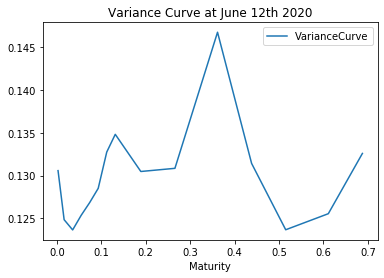

In [12]:
VarianceCurve = FuturePriceVIX[['Maturity','VarianceCurve']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
VarianceCurve.plot(title = 'Variance Curve at June 12th 2020')

Ainsi, à partir des courbes de variance calculées, il est possible de calculer le prix actuel des Futures VIX pour chaque maturité à partir d'une simulation Monte Carlo avec le modèle de Bergomi, pour ensuite les tracer :

In [13]:
T = FuturePriceVIX['Maturity']
sigma02 = FuturePriceVIX['VarianceCurve']
n = len(FuturePriceVIX)

FuturePriceVIX["FVIXBergomiPrice"] = [FVIXbergomiMC(T[i], sigma02[i],10000) for i in range(n)]
FuturePriceVIX.head()

,Symbol,Expiration_Date,Last,Change,High,Low,Settlement,Volume,Maturity,VarianceCurve,FVIXBergomiPrice
0,VIX,2020-06-12,0.3609,-4.70,0.4416,0.3497,0.36090,0,0.002740,0.130577,0.360907
1,VXM20,2020-06-17,0.3525,-5.38,0.4255,0.3495,0.35075,151177,0.016438,0.124858,0.350773
2,VX25M20,2020-06-24,0.4075,0.78,0.4075,0.3440,0.34625,30,0.035616,0.123666,0.346074
3,VX26N20,2020-07-01,0.3820,-1.83,0.4040,0.3445,0.34575,2,0.054795,0.125369,0.345811
4,VX27N20,2020-07-08,0.4090,0.80,0.4090,0.3455,0.34500,12,0.073973,0.126857,0.344830


Text(0.5, 1.0, 'Structure à terme des futures VIX le 12 Juin 2020')

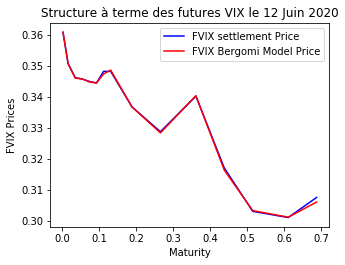

In [14]:
# On définit un dataframe contenant la volatilité implicite à deux facteurs des Puts en fonction du Strike en indice
term_structure = FuturePriceVIX[['Maturity','Settlement', 'FVIXBergomiPrice']].sort_values('Maturity')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(term_structure['Maturity'],term_structure['Settlement'], color = 'b', label = 'FVIX settlement Price')
plt.plot(term_structure['Maturity'],term_structure['FVIXBergomiPrice'], color = 'r', label = 'FVIX Bergomi Model Price')

plt.xlabel('Maturity')
plt.ylabel('FVIX Prices')
leg = ax.legend()
plt.title('Structure à terme des futures VIX le 12 Juin 2020')

Il est ainsi possible de constater qu'au vu de la similitude des prix du marché des Futures VIX et de ceux du modèle de Bergomi que le calcul de la courbe de variance $\xi_0^T$ a été correctement effectué, témoignant ainsi de la bonne calibration de la variable. Avec ce calcul, il est donc possible de calculer la volatilité implicite des options vanilles sur VIX sous le modèle de Bergomi.

## Calcul de la volatilité implicite des options vanilles sur VIX sous le modèle de Bergomi

### Formule close de Black Scholes adaptée pour les options vanilles sur VIX

Le prix actuel à l'instant $0$ d'une option sur VIX peut par ailleurs être approximé analytiquement. En effet, il s'agit d'utiliser la formule fermée de Black Scholes des options vanilles classiques en utilisant cette fois ci comme paramètre spot la valeur du future VIX, c'est à dire $FVIX_0^T = \mathbb{E}[VIX_T]$.

Rappelons que la formule de Black Scholes classique pour le prix d'un Call selon un sous-jacent $S$ est définie comme suit:

$C(t,S) = S \mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2)$ avec:

$d_1 = \frac{ln(S/K)+(r+\sigma^2/2)(T-t)}{\sigma \sqrt{(T-t)}}$ et

$d_2 = d_1 - \sigma \sqrt{(T-t)}$,

et $\mathcal{N}$ est la fonction de répartition d'une variable gaussienne centrée réduite.

Ainsi, en supposant le taux d'intérêt $r$ nul, le prix d'un Call sur VIX à l'instant 0 peut être exprimé comme suit :

$C_{VIX}(0) = FVIX_0^T \mathcal{N}(d_1) - K\mathcal{N}(d_2)$ avec:

$d_1 = \frac{ln(FVIX_0^T/K)+\frac{\sigma^2}{2}T}{\sigma \sqrt{T}}$ et

$d_2 = d_1 - \sigma \sqrt{T}$

La formule de Black Scholes pour un Call sur VIX est implémentée comme suit :

In [15]:
def VIXCallFormulaBS(FVIX,K,T,sigma):
    d1 = (math.log(FVIX/K)+(sigma**2/2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    C = FVIX*sps.norm.cdf(d1) - K*sps.norm.cdf(d2)
    return C

Dans le cas des Puts, d'après la formule de parité Call Put adaptée aux options sur VIX:

$$
C_{VIX}(t)-P_{VIX}(t)=FVIX_t^T-Ke^{-r(T-t)}
$$

C'est à dire à l'instant 0 et en supposant le taux d'intérêt $r$ nul :

$$
C_{VIX}(0)-P_{VIX}(0)=FVIX_0^T-K
$$

donc :

$$
P_{VIX}(0) = C_{VIX}(0)-FVIX_0^T+K
$$

Cependant, il est préférable d'implémenter la formule originale de Black Scholes d'un Put, pour un taux $r$ nul:

$P_{VIX}(0) = K\mathcal{N}(-d_2) - FVIX_0^T \mathcal{N}(-d_1)$

In [16]:
def VIXPutFormulaBS(FVIX,K,T,sigma):
    d1 = (math.log(FVIX/K)+(sigma**2/2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    P =  K*sps.norm.cdf(-d2) - FVIX*sps.norm.cdf(-d1)
    return P

### Volatilité implicite des Options vanilles sur VIX en utilisant les futures VIX du marché

Une fois de plus, la volatilité est l'unique paramètre inobservable dans le modèle de Black Scholes. Ainsi, la volatilité implicite est la volatilité du Call calibrée sur le modèle de Black Scholes afin que le prix du Call issu du modèle puisse coller avec celui observé sur le marché, que l'on note $C$. Cette volatilité est unique pour les raisons qui ont été expliqués dans le cas du modèle de Black Scholes classique, notamment celle de la bijectivité de la formule de Black Scholes en tant que fonction de la volatilité.

De ce fait, il est de même possible de retrouver la volatilité implicite via l'algorithme de Newton : 

$$
\sigma_0 = \sqrt{\frac{2|log(m)|}{T}}, m = \frac{FVIX_0^T}{K}
$$
$$
\sigma_{n+1} = \sigma_{n} + \frac{C - C^{BS}(\sigma_n)}{\frac{\partial C^{BS}}{\partial \sigma}(\sigma_n)}
$$

Sachant que le Vega du Call sur VIX est cette fois ci égal à :

$$
V = \frac{\partial C^{BS}}{\partial \sigma} = FVIX_0^T \sqrt{T} \frac{e^{-d_1^2/2}}{\sqrt{2\pi}} > 0
$$

Il y a cependant possibilité d'obtenir une volatilité implicite négative après calcul, ce qui n'est pas valable. Cela peut se produire pour les options fortement hors et dans la monnaie, où le spread bid-ask est grand. Pour cela, il convient de renvoyer une valeur manquante lorsque la volatilité implicite est négative.

Cet algorithme est implémentée comme suit :

In [17]:
def FVIXImpliedVolCall(FVIX,K,T,Call,N):
    m = FVIX/K
    sigma = math.sqrt(2*abs(math.log(m))/T)
    for i in range(N):
        d1 = (math.log(FVIX/K)+(sigma**2/2)*T)/(sigma*math.sqrt(T))
        Vega = (FVIX*math.sqrt(T))*(math.exp(-d1**2/2))/math.sqrt(2*math.pi)
        if Vega != 0:
            sigma+= (Call - VIXCallFormulaBS(FVIX,K,T,sigma))/Vega
        else :
            sigma+=0
    return np.nan if sigma <= 1.0e-6 else sigma

Sachant que le Vega des Puts est égal à celui des Calls, l'algorithme de calcul de la volatilité implicite pour les puts est pratiquement la même, et peut être implémentée comme suit :

In [18]:
def FVIXImpliedVolPut(FVIX,K,T,Put,N):
    m = FVIX/K
    sigma = math.sqrt(2*abs(math.log(m))/T)
    for i in range(N):
        d1 = (math.log(FVIX/K)+(sigma**2/2)*T)/(sigma*math.sqrt(T))
        Vega = (FVIX*math.sqrt(T))*(math.exp(-d1**2/2))/math.sqrt(2*math.pi)
        if Vega != 0:
            sigma+= (Put - VIXPutFormulaBS(FVIX,K,T,sigma))/Vega
        else :
            sigma+=0
    return np.nan if sigma <= 1.0e-6 else sigma

Cependant, il est plus judicieux d'utiliser la fonction fsolve de scipy.optimize pour trouver la racine de la fonction de variable $\sigma$ mesurant la différence entre le prix Black Scholes de l'option et celui observé sur le marché :

In [87]:
def FVIXImpliedVolCall(FVIX,K,T,Call):
    _FVIX, _K, _T, _Call = FVIX,K,T,Call
    difference_call = lambda sigma : _Call - VIXCallFormulaBS(_FVIX, _K, _T,sigma)
    iv = spop.brentq(difference_call, -100,100)
    return iv

def FVIXImpliedVolPut(FVIX,K,T,Put):
    _FVIX, _K, _T, _Put = FVIX,K,T,Put
    difference_put = lambda sigma : Put - VIXPutFormulaBS(_FVIX, _K, _T,sigma)
    iv = spop.brentq(difference_put, -100,100)
    return iv

Ainsi, pour un ensemble d'options sur VIX ayant différentes maturités $T$ et Strike $K$, il est possible de calculer l'ensemble des volatilités implicites. Pour cela, il convient de télécharger les données sur ces options.

### Chargement et traitement des données contenant le prix des options sur VIX

Les données des options traités par le Cboe ont été téléchargés depuis la plateforme Cboe delayed quotes, et proviennent d'une cotation effectuée le 12 Juin 2020. La date d'expiration pour chaque option est renseignée, ce qui permet d'en déduire chaque maturité.

In [64]:
CallPriceVIX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/VIXCallData.xlsx")
PutPriceVIX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/VIXPutData.xlsx")

Dans un premier temps, il convient d'harmoniser le format de la date d'expiration, et ainsi de construire la variable de maturité pour chaque option sachant que la cotation a eu lieu le 12 Juin 2020.

In [65]:
from datetime import timedelta
from datetime import date

n = len(CallPriceVIX['Expiration_Date'])
Expiration_Date = CallPriceVIX['Expiration_Date']

# Déclaration du vecteur Date de composantes égales au 12 Juin 2020
Today=[0 for i in range(n)]
for i in range(n):
    Today[i] = str('2020-06-12')
Today = pd.to_datetime(Today)

# Expression de la différence entre l'expiration et la date du 25 Mai 2020
time_difference = Expiration_Date - Today

# Conversion de la différence en nombre entier de jours, sachant que le type du vecteur est timedelta
m = len(time_difference)
Time_difference = [int(time_difference[i]/np.timedelta64(1, 'D')) for i in range(m)]

# Calcul de la maturité des Options et ajout dans le jeu de données
CallPriceVIX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]
PutPriceVIX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]

Une fois de plus, la cotation des VIX étant côtée en pourcentage, il convient de diviser la valeur des Strikes, des prix Bid, Ask et Last par 100 :

In [66]:
CallPriceVIX["Strike"] = CallPriceVIX["Strike"]/100
CallPriceVIX["Bid"] = CallPriceVIX["Bid"]/100
CallPriceVIX["Ask"] = CallPriceVIX["Ask"]/100
CallPriceVIX["Last_Sale"] = CallPriceVIX["Last_Sale"]/100
PutPriceVIX["Strike"] = PutPriceVIX["Strike"]/100
PutPriceVIX["Bid"] = PutPriceVIX["Bid"]/100
PutPriceVIX["Ask"] = PutPriceVIX["Ask"]/100
PutPriceVIX["Last_Sale"] = PutPriceVIX["Last_Sale"]/100

Il est par ailleurs coutume d'utiliser comme valeur de référence le prix Mid, qui est la moyenne entre les prix Bid et Ask. qui est considéré comme le prix représentant au mieux celui de l'option observé sur le marché. De ce fait, nous implémentons la fonction calculant cette quantité. Si tous les deux prix sont manquantes, on utilise le prix Last qui est le prix fixé lors de la dernière transaction.

In [67]:
def get_fair_price(data):
    Bid = data["Bid"]
    Ask = data["Ask"]
    Last = data["Last_Sale"]
    # On retourne 0 si le bid ou le ask est manquante
    if np.isnan(Bid) or np.isnan(Ask):
        return 0.0
    # On retourne le dernier prix de trade si le bid ou le ask est nul
    elif Bid == 0.0 or Ask == 0.0:
        return Last
    else:
        return (Bid+Ask)/2.0

In [68]:
# Rajout du prix Mid au jeu de données
CallPriceVIX['Mid'] = CallPriceVIX.apply(get_fair_price, axis=1)
PutPriceVIX['Mid'] = PutPriceVIX.apply(get_fair_price, axis=1)

In [69]:
CallPriceVIX.head()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
0,2020-06-17,VIX200617C00010000,0.286,0.5,0.249,0.252,47,10.9525,0.9486,0.0024,1277,0.100,0.016438,0.2505
1,2020-06-17,VIX200617C00010500,0.000,0.0,0.244,0.247,0,10.5501,0.9459,0.0026,0,0.105,0.016438,0.2455
2,2020-06-17,VIX200617C00011000,0.147,0.0,0.239,0.242,0,10.1714,0.9431,0.0028,668,0.110,0.016438,0.2405
3,2020-06-17,VIX200617C00011500,0.000,0.0,0.234,0.237,0,9.8140,0.9404,0.0030,0,0.115,0.016438,0.2355
4,2020-06-17,VIX200617C00012000,0.284,2.3,0.229,0.232,1,9.4790,0.9376,0.0032,253,0.120,0.016438,0.2305


In [70]:
PutPriceVIX.head()

,Expiration_Date,Puts,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
0,2020-06-17,VIX200617P00010000,0.0005,0.0,0.0,0.0005,0,4.5987,-0.0039,0.0006,1305,0.100,0.016438,0.0005
1,2020-06-17,VIX200617P00010500,0.0000,0.0,0.0,0.0005,0,4.4082,-0.0039,0.0007,0,0.105,0.016438,0.0000
2,2020-06-17,VIX200617P00011000,0.0003,0.0,0.0,0.0005,0,4.2815,-0.0043,0.0007,1824,0.110,0.016438,0.0003
3,2020-06-17,VIX200617P00011500,0.0000,0.0,0.0,0.0005,0,4.0933,-0.0043,0.0008,0,0.115,0.016438,0.0000
4,2020-06-17,VIX200617P00012000,0.0002,0.0,0.0,0.0005,0,3.9385,-0.0044,0.0008,21886,0.120,0.016438,0.0002


Par ailleurs, le paramètre spot, c'est à dire le future VIX qui est $VIX_0^T$, n'a pas été spécifié dans le jeu de données. Il convient donc de faire la jointure entre le prix des options sur VIX ainsi que celui des Futures VIX en fonction de la date d'expiration, qui est considérée comme index pour chacune des jeux de données. Pour cela, on définit le nouvel index pour les deux jeux de données.

In [71]:
# On indexe la DataFrame des Calls et des Futures
# par ladite colonne afin d'effectuer la jointure ultérieurement selon les index

CallPriceVIX = CallPriceVIX.set_index("Expiration_Date")
PutPriceVIX = PutPriceVIX.set_index("Expiration_Date")
FuturePriceVIX = FuturePriceVIX.set_index("Expiration_Date")

Le prix des Futures qui nous intéresse est le prix de Settlement qui est le prix fixé lors de la dernière transaction ayant eu lieu.

Ainsi, la jointure (selon une procédure Left Join) se fait selon l'index qui est la date d'expiration des Calls et Futures, sachant qu'ils ont été côtés au même moment. La seule variable jointe à la base de données des Calls est le Settlement Price des Futures VIX.

In [72]:
# On joint selon une procédure Left Join la table des Calls avec celle du prix du sous-jacent, selon l'index
CallPriceVIX = CallPriceVIX.join(FuturePriceVIX["Settlement"])
PutPriceVIX = PutPriceVIX.join(FuturePriceVIX["Settlement"])

La nouvelle variable jointe est renommée :

In [73]:
# On renomme la colonne Close par Underlying_Price
columns = {'Settlement':'FVIX_Settlement_Price'}
CallPriceVIX.rename(columns=columns, inplace = True)
PutPriceVIX.rename(columns=columns, inplace = True)

# On réinitialise les Index
CallPriceVIX=CallPriceVIX.reset_index()
PutPriceVIX=PutPriceVIX.reset_index()
FuturePriceVIX=FuturePriceVIX.reset_index()

CallPriceVIX.head()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid,FVIX_Settlement_Price
0,2020-06-17,VIX200617C00010000,0.286,0.5,0.249,0.252,47,10.9525,0.9486,0.0024,1277,0.100,0.016438,0.2505,0.35075
1,2020-06-17,VIX200617C00010500,0.000,0.0,0.244,0.247,0,10.5501,0.9459,0.0026,0,0.105,0.016438,0.2455,0.35075
2,2020-06-17,VIX200617C00011000,0.147,0.0,0.239,0.242,0,10.1714,0.9431,0.0028,668,0.110,0.016438,0.2405,0.35075
3,2020-06-17,VIX200617C00011500,0.000,0.0,0.234,0.237,0,9.8140,0.9404,0.0030,0,0.115,0.016438,0.2355,0.35075
4,2020-06-17,VIX200617C00012000,0.284,2.3,0.229,0.232,1,9.4790,0.9376,0.0032,253,0.120,0.016438,0.2305,0.35075


### Calcul de la volatilité implicite des Options sur VIX

Avec la fonction précédemment implémentée, la volatilité implicite est ainsi calibré sur l'ensemble des prix Mid des options exprimés en fonction du strike $K$ et de maturité $T$, sachant que tous les paramètres requis en entrée sont à notre disposition.

In [74]:
def all_implied_Vol_Call(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    Mid = data["Mid"]
    return float(FVIXImpliedVolCall(FVIX,K,T,Mid))

def all_implied_Vol_Put(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    Mid = data["Mid"]
    return float(FVIXImpliedVolPut(FVIX,K,T,Mid))

In [75]:
CallPriceVIX["Implied_Volatility"] = CallPriceVIX.apply(all_implied_Vol_Call, axis = 1)
PutPriceVIX["Implied_Volatility"] = PutPriceVIX.apply(all_implied_Vol_Put, axis = 1)

In [76]:
CallPriceVIX.tail()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid,FVIX_Settlement_Price,Implied_Volatility
412,2020-11-18,VIX201118C00080000,0.0080,-0.175,0.0080,0.0085,1047,0.9312,0.1160,0.0100,3803,0.80,0.438356,0.00825,0.317,0.918540
413,2020-11-18,VIX201118C00085000,0.0075,-0.100,0.0055,0.0075,26,0.9345,0.0990,0.0089,2138,0.85,0.438356,0.00650,0.317,0.911847
414,2020-11-18,VIX201118C00090000,0.0075,0.000,0.0050,0.0065,1,0.9431,0.0866,0.0080,856,0.90,0.438356,0.00575,0.317,0.925910
415,2020-11-18,VIX201118C00095000,0.0070,0.075,0.0040,0.0060,20,0.9611,0.0793,0.0073,674,0.95,0.438356,0.00500,0.317,0.934859
416,2020-11-18,VIX201118C00100000,0.0045,-0.125,0.0035,0.0055,774,0.9580,0.0671,0.0065,31557,1.00,0.438356,0.00450,0.317,0.948053


In [77]:
PutPriceVIX.tail()

,Expiration_Date,Puts,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid,FVIX_Settlement_Price,Implied_Volatility
412,2020-11-18,VIX201118P00080000,0.5120,0.0,0.487,0.493,0,0.696,-0.9617,0.0056,36,0.80,0.438356,0.490,0.317,0.885886
413,2020-11-18,VIX201118P00085000,0.0000,0.0,0.536,0.542,0,0.598,-0.9884,0.0023,24,0.85,0.438356,0.539,0.317,0.897039
414,2020-11-18,VIX201118P00090000,0.6240,0.0,0.585,0.591,0,0.000,-0.9110,0.0080,45,0.90,0.438356,0.588,0.317,0.901265
415,2020-11-18,VIX201118P00095000,0.6675,0.0,0.634,0.640,0,0.000,-0.9224,0.0072,28,0.95,0.438356,0.637,0.317,0.897749
416,2020-11-18,VIX201118P00100000,0.7110,0.0,0.683,0.689,0,0.000,-0.9342,0.0064,219,1.00,0.438356,0.686,0.317,0.884629


### Comparaison de la volatilité implicite calculée avec celle observée

Il convient de comparer la volatilité implicite calculée des options avec celles que l'on peut observer sur le marché pour chaque Strike. Pour cela, les deux volatilités implicites selon la date d'expiration du 16 Septembre 2020 et donc de la maturité de 3 mois sont tracées sur un même graphe.

Pour le Call : 

Text(0.5, 1.0, 'Comparison IV of Calls, Maturity 3 months')

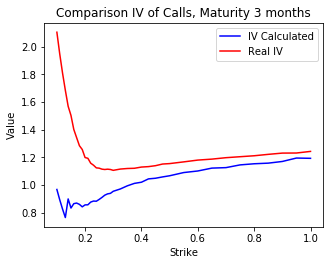

In [78]:
# On garde les Calls de ténor d'environ 3 mois
iv_strike = CallPriceVIX[CallPriceVIX['Expiration_Date']=='2020-09-16']
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_calculated = iv_strike[['Strike','Implied_Volatility']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_observed = iv_strike[['Strike','IV']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_calculated['Strike'],iv_strike_calculated['Implied_Volatility'], color = 'b', label = 'IV Calculated')
plt.plot(iv_strike_calculated['Strike'],iv_strike_observed['IV'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Calls, Maturity 3 months')

Et concernant les Puts :

Text(0.5, 1.0, 'Comparison IV of Puts, Maturity 3 months')

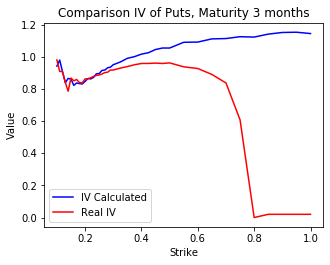

In [79]:
# On garde les Calls de ténor d'environ 3 mois
iv_strike = PutPriceVIX[PutPriceVIX['Expiration_Date']=='2020-09-16']
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_calculated = iv_strike[['Strike','Implied_Volatility']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_observed = iv_strike[['Strike','IV']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_calculated['Strike'],iv_strike_calculated['Implied_Volatility'], color = 'b', label = 'IV Calculated')
plt.plot(iv_strike_calculated['Strike'],iv_strike_observed['IV'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Puts, Maturity 3 months')

Le smile de volatilité pour les options sur VIX, contrairement à celles sur les equities, possède cette courbe positive et concave qui lui est caractéristique.

Cette caractéristique est parfaitement capturée par notre calcul de la volatilité implicite via la formule de Black Scholes. En revance, cela n'est point le cas pour le smile du marché, où il est possible de voir des volatilités implicite égales à zéro à partir d'un certain Strike de Put, ou bien une volatilité tendant vers l'infini lorsque le Strike est décroissant pour les Calls. Il est possible, bien que très surprenant, que la CBOE ait fait des erreurs de calculs.

### Calcul de la volatilité implicite des options vanilles par le modèle de Bergomi

La volatilité implicite des options sur VIX selon le modèle de Bergomi est la volatilité $\sigma_{imp}$ qui est telle que le prix des options calculé selon le modèle de Black Scholes, dont le paramètre spot est le Future VIX soit égal à celui calculé par le modèle de Bergomi. Ainsi, elle est définie telle que :
    
$$
P_{VIX,BS}(\sigma_{imp}^2,T,K) = P_{VIX,Bergomi}(T,K)
$$

Avec comme précédemment dans le cas des Calls et selon un taux d'intérêt nul :

$C_{VIX,BS}(\sigma^2,T,K)  = FVIX_0^T \mathcal{N}(d_1) - K\mathcal{N}(d_2)$ avec:

$d_1 = \frac{ln(FVIX_0^T/K)+\frac{\sigma^2}{2}T}{\sigma \sqrt{T}}$ et

$d_2 = d_1 - \sigma \sqrt{T}$

Cela équivaut à établir que $\sigma_{imp}$ est une racine de fonction :

$$
\sigma_{imp} = root_\sigma (P_{VIX,BS}(\sigma^2,T,K) - P_{VIX,Bergomi}(T,K))
$$

Ici, la volatilité implicite sera calculée pour l'ensemble des Calls et Puts sur VIX dont la date d'expiration est le 16 Septembre 2020, quelque soit les Strikes.

Dans un premier temps, le prix des options sur VIX selon le modèle de Bergomi sera calculé pour chaque Strike sachant que la valeur de la courbe de variance $\sigma_0^2$ constante par morceau est égale :

In [80]:
sigma02 = FuturePriceVIX[FuturePriceVIX['Expiration_Date']=='2020-09-16']['VarianceCurve'].iloc[0]
print(sigma02)

0.13084661138838374


In [81]:
# Pricing Monte Carlo pour les Calls de maturité 3 mois
CallPriceVIX_3M = CallPriceVIX[CallPriceVIX['Expiration_Date']=='2020-09-16']
n = len(CallPriceVIX_3M)
CallPriceVIX_3M['Index'] =[i for i in range (n)]
CallPriceVIX_3M = CallPriceVIX_3M.set_index('Index')

sigma02 = FuturePriceVIX[FuturePriceVIX['Expiration_Date']=='2020-09-16']['VarianceCurve'].iloc[0]
K = CallPriceVIX_3M["Strike"]
T = CallPriceVIX_3M["Maturity"]
Bergomi_Price =[0 for i in range(n)]
for i in range(n):
    Bergomi_Price[i] = VIXCallbergomiMC(K[i],T[i], sigma02, 10000)

CallPriceVIX_3M['Bergomi_Price'] = Bergomi_Price

# Pricing Monte Carlo pour les Puts de maturité de 3 mois
PutPriceVIX_3M = PutPriceVIX[PutPriceVIX['Expiration_Date']=='2020-09-16']
n = len(PutPriceVIX_3M)
PutPriceVIX_3M['Index'] =[i for i in range (n)]
PutPriceVIX_3M = PutPriceVIX_3M.set_index('Index')

K = PutPriceVIX_3M["Strike"]
T = PutPriceVIX_3M["Maturity"]
Bergomi_Price =[0 for i in range(n)]
for i in range(n):
    Bergomi_Price[i] = VIXPutbergomiMC(K[i],T[i], sigma02, 10000)

PutPriceVIX_3M['Bergomi_Price'] = Bergomi_Price

C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Une fois les prix selon le modèle de Bergomi sont calculés, les fonctions de calculs de la volatilité implicite sont modifiés et le calcul est effectué :

In [88]:
def all_implied_Vol_Call_Bergomi(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    BergomiPrice = data["Bergomi_Price"]
    return float(FVIXImpliedVolCall(FVIX,K,T,BergomiPrice))

def all_implied_Vol_Put_Bergomi(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    BergomiPrice = data["Bergomi_Price"]
    return float(FVIXImpliedVolPut(FVIX,K,T,BergomiPrice))

In [89]:
CallPriceVIX_3M["Implied_Volatility_Bergomi"] = CallPriceVIX_3M.apply(all_implied_Vol_Call_Bergomi, axis = 1)
PutPriceVIX_3M["Implied_Volatility_Bergomi"] = PutPriceVIX_3M.apply(all_implied_Vol_Put_Bergomi, axis = 1)

### Traçage de la volatilité implicite sous le modèle de Bergomi

Il est maintenant possible de tracer la volatilité implicite des Calls sur VIX en fonction du Strike et de le comparer à la volatilité réelle.

Dans le cas du Smile de volatilité, pour une maturité d'environ 3 mois, le code correspondant est le suivant:

Text(0.5, 1.0, 'Comparison IV of Calls, Maturity 3 months')

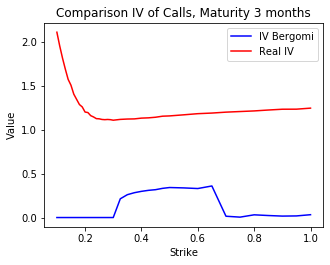

In [90]:
# On définit un dataframe contenant la volatilité implicite Bergomi des Calls en fonction du Strike en indice
iv_strike_bergomi = CallPriceVIX_3M[['Strike','Implied_Volatility_Bergomi']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite Réelle des Calls en fonction du Strike en indice
iv_strike_observed = CallPriceVIX_3M[['Strike','IV']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['Implied_Volatility_Bergomi'], color = 'b', label = 'IV Bergomi')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['IV'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Calls, Maturity 3 months')

De même pour les Puts de maturité 3 mois :

Text(0.5, 1.0, 'Comparison IV of Puts, Maturity 3 months')

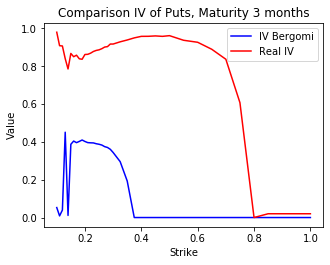

In [91]:
# On définit un dataframe contenant la volatilité implicite Bergomi des Puts en fonction du Strike en indice
iv_strike_bergomi = PutPriceVIX_3M[['Strike','Implied_Volatility_Bergomi']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite Réelle des Puts en fonction du Strike en indice
iv_strike_observed = PutPriceVIX_3M[['Strike','IV']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['Implied_Volatility_Bergomi'], color = 'b', label = 'IV Bergomi')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['IV'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Puts, Maturity 3 months')

Il est possible de constater que le smile de volatilité des options de maturité 3 mois calculé par le modèle de Bergomi à un facteur est bien plus plat que celui observé sur le marché, concordant ainsi avec la théorie. Mais la courbe n'est pas du tout caractéristique du Smile des options sur VIX, d'autant plus que les valeurs sont proches, vore égale à zéro pour plusieurs Strikes. Il faut donc revoir le calcul de la volatilité implicite sous le modèle de Bergomi. 

Cependant, il serait intéressant de tracer en fonction du Strike et comparer le prix sous le modèle de Bergomi des Calls de Maturité 3 mois, avec celui du marché, afin d'analyser son comportement et possiblement d'expliquer la structure théoriquement plate du Smile de volatilité des options sous ce modèle :

Text(0.5, 1.0, 'Price comparison of Calls, Maturity 3 months')

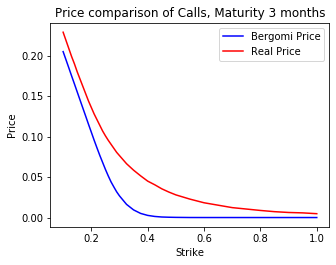

In [92]:
# On définit un dataframe contenant le prix Bergomi des Calls en fonction du Strike en indice
iv_strike_bergomi = CallPriceVIX_3M[['Strike','Bergomi_Price']].sort_values('Strike')

# On définit un dataframe contenant le prix Mid du marché des Calls en fonction du Strike en indice
iv_strike_observed = CallPriceVIX_3M[['Strike','Mid']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['Bergomi_Price'], color = 'b', label = 'Bergomi Price')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['Mid'], color = 'r', label = 'Real Price')
plt.xlabel('Strike')
plt.ylabel('Price')
leg = ax.legend()
plt.title('Price comparison of Calls, Maturity 3 months')

Au final, la trajectoire du prix du Call sous le modèle de Bergomi semble caractéristiques des Calls de maturité courte voire très courte, ou dont la date d'expiration est proche ou très proche. Cela est tout aussi surprenant puisque les options de courte maturités ont la particularité d'avoir un Smile de volatilité prononcé par rapport à ceux de longue maturité. Or l'inconvénient théorique du mod_le de Bergomi à un facteur est qu'il reproduit un Smile trop plat par rapport à ce qui peut être observé sur le marché. Peut être qu'il faudra revoir la formule Monte Carlo du modèle de Bergomi.

Afin de combler les limites du modèle de Bergomi à un facteur, Lorenzo Bergomi a introduit un autre modèle à deux facteurs, permettant de reproduire un Smile de volatilité donc des prix d'options bien plus fidèle ,au marché par rapport à son prédécesseur à un facteur :

## Pricing d'options sur VIX sous un modèle de Bergomi à deux facteurs

Il est connu que le modèle ci-dessus produit un smile de volatilité implicite pour les options sur VIX qui est trop plat par rapport à ce que l'on observe sur le marché. On peut cependant considérer une modification du modèle, qui est capable de générer le fort skew positif typique des smiles VIX marché.

Notons l'exponentiel de Doléans-Dade: 

$$
\mathcal{E}(\int_{0}^{t} \varphi (T-s) dW_s) = exp(\int_{0}^{t} \varphi (T-s) dW_s - \frac{1}{2}\int_{0}^{t} \varphi^2 (T-s) ds)
$$

Alors que le premier modèle spécifié, celui de Bergomi, sachant que $\varphi(T-s) = \omega e^{-k(T-s)}$, était tel que:

$$
\xi_t^T = \xi_0^Te^{\int_{0}^{t} \varphi (T-s) dW_s - \frac{1}{2} \int_{0}^{t} \varphi^2 (T-s) ds} = \xi_0^T \mathcal{E}(\int_{0}^{t} \varphi (T-s) dW_s), \ \forall t \leq T
$$
Le nouveau modèle de Bergomi à deux facteurs est le suivant :

$$
d\xi_t^T = \omega \alpha_{\gamma} \xi_t^T [(1-\gamma)e^{-k_1 (T-t)}dW_t^1 + \gamma e^{-k_2 (T-t)}dW_t^2] \\
\xi_0^T = \xi_0^{T, mkt}
$$

avec $T \rightarrow \xi_0^{T, mkt}$ la courbe de variance forward instantanée initiale donnée par le marché en $t=0$, et $\alpha_{\gamma} = 1/\sqrt{(1-\gamma)^2 + \gamma^2 + 2\rho_{12} \gamma (1-\gamma)}$.

Ici, les deux mouvements browniens $W_t^1$ et $W_t^2$ ont une corrélation égale à $\rho_{12}$.

la formule d'Itô appliqué au changement de variable : $ln(\xi_t^T)$ donne ainsi :

$$
dln(\xi_t^T) = (1-\gamma)(\omega \alpha_{\gamma} e^{-k_1 (T-t)} dW_t^1 - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_1(T-t)} d<W^1>_t) + \gamma (\omega \alpha_{\gamma} e^{-k_2 (T-t)} dW_t^2 - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_2(T-t)} <W^2>_t) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}d<W^1,W^2>_t
$$

Ainsi, par intégration entre 0 et $t$ et élévation à l'exponentiel, la solution de l'équation différentielle stochastique initiale est :

$$
\xi_t^T = \xi_0^T exp((1-\gamma)(\omega \alpha_{\gamma} e^{-k_1 (T-t)} dW_t^1 - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_1(T-t)} d<W^1>_t) + \gamma (\omega \alpha_{\gamma} e^{-k_2 (T-t)} dW_t^2 - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_2(T-t)} <W^2>_t) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}d<W^1,W^2>_t)
$$


Enfin, en se rappelant que : 

- $\int_{0}^{t} \omega \alpha_{\gamma} e^{-k_1 (u-s)} dW_s^1 = \omega \alpha_{\gamma} e^{-k_1 (u-t)} X_{t}$
- $\int_{0}^{t} \omega \alpha_{\gamma} e^{-k_2 (u-s)} dW_s^2 = \omega \alpha_{\gamma} e^{-k_2 (u-t)} Y_{t}$
- $\int_{0}^{t} (\omega \alpha_{\gamma})^2 e^{-(k_1+k_2) (u-s)} d<W^1,W^2>_s = (\omega \alpha_{\gamma})^2 e^{-(k_1+k_2) (u-t)}Cov[X_{t},Y_{t}]$  

où $(X_t)$ et $(Y_t)$ sont respectivement des processus d'Ornstein-Uhlenbeck de condition initiale est $X_0 = 0$ et de dynamique respectives : $dX_t = k_1X_t + dW_t^1$ et $dY_t = k_2 Y_t + dW_t^2$. La solution de l'équation différentielle stochastique précédente peut être réécrite comme suit :

$$
\xi_t^T = \xi_0^T exp((1-\gamma)(\omega \alpha_{\gamma} e^{-k_1(T-t)}X_t - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_1(T-t)} \mathbb{E}[X_t^2]) + \gamma (\omega \alpha_{\gamma} e^{-k_2(T-t)}Y_t - \frac{\omega^2}{2} e^{-2k_2(T-t)} \mathbb{E}[Y_t^2]) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}\mathbb{E}[X_t Y_t]), \forall t \leq T
$$

C'est à dire pour $0 \leq T \leq u$: 

$$
\xi_T^u = \xi_0^u exp((1-\gamma)(\omega \alpha_{\gamma} e^{-k_1(u-T)}X_T - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_1(u-T)} \mathbb{E}[X_T^2]) + \gamma (\omega \alpha_{\gamma} e^{-k_2(u-T)}Y_T - \frac{(\omega \alpha_{\gamma}=^2}{2} e^{-2k_2(u-T)} \mathbb{E}[Y_T^2]) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(u-T)}\mathbb{E}[X_T Y_T])
$$

Les trois espérances, qui sont la variance et la covariance des variables $X_T$ et $Y_T$, sont respectivement égales à :

- $\mathbb{E}[X_T^2] = \frac{1- e^{-2k_1T}}{2k_1}$
- $\mathbb{E}[Y_T^2]= \frac{1- e^{-2k_2T}}{2k_2}$
- $\mathbb{E}[X_T Y_T]= \rho_{12}\frac{1- e^{-(k_1+k_2)T}}{k_1+k_2}$

De ce fait, en posant : 

- $Y_1(T,u) = \omega \alpha_{\gamma} e^{-k_1 (u-T)} X_{T}$
- $Y_2(T,u) = \omega \alpha_{\gamma} e^{-k_2 (u-T)} Y_{T}$ 
- $h_1(T,u) = Var[Y_1(u)]$
- $h_2(T,u) = Var[Y_2(u)]$
- $h_3(T,u) = Cov[Y_1(u), Y_2(u)]$

nous avons pour $0 \leq T \leq u$: 

$$
\xi_T^u = \xi_0^u exp((1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)), \forall t \leq T
$$

#### Rappel : pricing d'un Call sous le modèle de Bergomi

 Sous le modèle de Bergomi, pour $0 \leq T \leq u$  le prix actuel d'un Call sur VIX à l'instant $0$ est donné par :

$$
P_0(T) = \Psi_{Bergomi} (0, (\xi_0^{u})_{u \in [T, T+\delta]}),
$$

où : 

$$
\Psi_{Bergomi} (0, x(.)) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) e^{\int_{0}^{T} \varphi (u-s) dW_s - \frac{1}{2} \int_{0}^{T} \varphi^2 (u-s) ds} du} - K)_{+}] = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) \mathcal{E}(\int_{0}^{t} \varphi (u-s) dW_s) du} - K)_{+}]
$$

C'est à dire en posant 

- $Y(T,u) = \int_{0}^{T} \varphi (u-s) dW_s$
- $h(T,u) = Var[Y(u)] = \int_{0}^{T} \varphi^2 (u-s) ds$ :

$$
\Psi_{Bergomi} (0, x(.)) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) e^{Y(T,u) - \frac{1}{2} h(T,u)} du} - K)_{+}]
$$

Ce qui veut dire que: 

$$
\mathcal{E}(\int_{0}^{T} \varphi (u-s) dW_s) = e^{Y(T,u) - \frac{1}{2} h(T,u)}
$$

#### pricing Monte Carlo d'un Call sous le modèle à deux facteurs

En s'inspirant du raisonnement effectué précédemment, dans le cas du modèle de Bergomi à deux facteurs, sachant que en posant : 

- $Y_1(T,u) = \omega \alpha_{\gamma} e^{-k_1 (u-T)} X_{T}$
- $Y_2(T,u) = \omega \alpha_{\gamma} e^{-k_2 (u-T)} Y_{T}$ 
- $h_1(T,u) = Var[Y_1(u)]$
- $h_2(T,u) = Var[Y_2(u)]$
- $h_3(T,u) = Cov[Y_1(u), Y_2(u)]$

nous avons pour $0 \leq T \leq u$: 

$$
\xi_T^u = \xi_0^u exp((1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)), \forall t \leq T
$$

Alors le prix actuel d'un Call sur VIX à l'instant $0$ est donné par :

$$
P_0(T) = \Psi_{Bergomi} (0, (\xi_0^{u})_{u \in [T, T+\delta]}),
$$

où : 

$$
\Psi (0, x(.)) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{1}{\delta} \int_{T}^{T+\delta} x(u) e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)} du} - K)_{+}]
$$

Ainsi, Sachant que : 

- $Y_1(T,u) = \omega \alpha_{\gamma} e^{-k_1 (u-T)} X_{T}$
- $Y_2(T,u) = \omega \alpha_{\gamma} e^{-k_2 (u-T)} Y_{T}$ 

$X_T$ et $Y_T$ étant des processus d'Ornstein Uhlenbeck définis précédemment,

les fonctions aléatoires$Y_1(u)$ et $Y_2(u)$ peuvent donc directement être simulés très simplement en générant une réalisation des variable $X_T$ et $Y_T$ en multipliant respectivement par $\omega \alpha_{\gamma} e^{-k_1(u-T)}$, et $\omega \alpha_{\gamma} e^{-k_2(u-T)}$ pour $u \in [T,T+\delta]$.

Par la suite, la courbe de variance est $x(u) = \xi_0^u$ que l'on fixe une fois de plus ici comme une constante égale à $\sigma_0^2$.

Ainsi finalement, 

$$
P_0(T) = \mathbb{E}^{\mathbb{Q}}[(\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta} e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u_i)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du} - K)_{+}]
$$

Une fois de plus, la quantité $(\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta} e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u_i)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du} - K)_{+}$ est une variable aléatoire, fonction de $X_T$ et $Y_T$ les processus d'Ornstein Uhlenbeck d'espérance 0. Cette fonction est une fois de plus nommée $g$. Ainsi, cela permet d'obtenir : 

$$
P_0(T) = \mathbb{E}^{\mathbb{Q}}[g(X_T,Y_T)]
$$

Et son estimation Monte Carlo peut être donnée, pour $M$ suffisamment grand et grâce à $M$ réalisations $X_T^j$ et $Y_T^j$ des variable $X_T$ et $Y_T$ respectivement, par:

$$
P_0(T) \approx \frac{1}{M}\sum_{j=1}^{M}g(X_T^j, Y_T^j)
$$

Une fois de plus, la méthode des variables antithétiques sera privilégiée, ce qui implique que l'estimateur Monte Carlo sera finalement donné par :

$$
P_0(T) \approx \frac{1}{M}\sum_{j=1}^{M}\frac{g(X_T^j, Y_T^j) + g(-X_T^j, -Y_T^j)}{2}
$$

Les étapes du pricing Monte Carlo du prix d'un Call sur VIX pour le modèle à deux facteurs sont les mêmes que celles pour le modèle de Bergomi à un facteur. Seule la fonction $g$ varie. Celle ci est égale une fois de plus à :

$$
g(X_T,Y_T) = (\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta} e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u_i)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du} - K)_{+}
$$

Concernant le Put, 

$$
g(X_T,Y_T) = (K-\sqrt{\frac{\sigma_0^2}{\delta} \int_{T}^{T+\delta} e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u_i)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du})_{+}
$$

Dans la pratique, $\omega \approx 2$, $k_1$ et $k_2$ ont des valeurs éloignées entre elles, et $\gamma = 0.5$. les valeurs des paramètres seront ici fixées arbitrairement  de manière suivante : $\sigma_0^2 = 0.08$, $\gamma = 0.15$, $\omega = 4$, $k1 = 5$, $k_2 = 0.05$ et $\rho_{12} = 0.75$.

Le pricing peut être implémenté comme suit pour le prix d'un Call ainsi que celui d'un Put :

In [93]:
def VIXCallTwoFactorsBergomiMC(K, T, sigma02, M, w= 4, gamma = 0.15, k1 = 5, k2 = 0.05, rho12 = 0.75):
    delta=1/12
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    
    ####### Simulation multivariée des processus d'Ornstein Uhlenbeck
    # Calcul de la variance et Covariance des processus OU
    Var_X = (1/(2*k1))*(1-math.exp(-2*k1*T))
    Var_Y = (1/(2*k2))*(1-math.exp(-2*k2*T))
    Cov_XY = rho12*(1/(k1+k2))*(1-math.exp(-(k1+k2)*T))
    
    # Creation matrice de variance covariance
    covariance = np.matrix([
        [Var_X, Cov_XY], 
        [Cov_XY, Var_Y]
    ])  
    L = np.linalg.cholesky(covariance)
    
    # Simulation de M réalisations d'une variable gaussienne centrée réduite de dimension 2
    d = 2 # Dimension
    Gaussian = np.random.normal(size=(d, M))
    
    # Création du vecteur d'Ornstein Uhlenbeck, composé des variables X_T et Y_T
    Multivariate_Ornstein_Uhlenbeck = L.dot(Gaussian)
    X_T = [Multivariate_Ornstein_Uhlenbeck[0,i] for i in range(M)]
    Y_T = [Multivariate_Ornstein_Uhlenbeck[1,i] for i in range(M)]
    
    ####### Definition des fonctions à intégrer entre T et T+ delta
    def f(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*X_T[i] - 0.5*h1) + gamma*(phi2*Y_T[i]- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    def g(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*(-X_T[i]) - 0.5*h1) + gamma*(phi2*(-Y_T[i])- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    
    ####### Intégration et somme Monte Carlo
    G=0
    for i in range(M):
        fun_to_integrate = lambda u : f(u,i)
        fun_to_integrate_antithetic = lambda u : g(u,i)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (max(math.sqrt((sigma02/delta)*integration) - K, 0) + max(math.sqrt((sigma02/delta)*antithetic_integration) - K, 0))/2
    P0_Call = G/M
    return P0_Call

def VIXPutTwoFactorsBergomiMC(K, T, sigma02, M, w= 4, gamma = 0.15, k1 = 5, k2 = 0.05, rho12 = 0.75):
    delta=1/12
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    
    ####### Simulation multivariée des processus d'Ornstein Uhlenbeck
    # Calcul de la variance et Covariance des processus OU   
    Var_X = (1/(2*k1))*(1-math.exp(-2*k1*T))
    Var_Y = (1/(2*k2))*(1-math.exp(-2*k2*T))
    Cov_XY = rho12*(1/(k1+k2))*(1-math.exp(-(k1+k2)*T))
    
    # Creation matrice de variance covariance
    covariance = np.matrix([
        [Var_X, Cov_XY], 
        [Cov_XY, Var_Y]
    ])  
    L = np.linalg.cholesky(covariance)
    
    # Simulation de M réalisations d'une variable gaussienne centrée réduite de dimension 2
    d = 2 # Dimension
    Gaussian = np.random.normal(size=(d, M))
    # Création du vecteur d'Ornstein Uhlenbeck, composé des variables X_T et Y_T
    Multivariate_Ornstein_Uhlenbeck = L.dot(Gaussian)
    X_T = [Multivariate_Ornstein_Uhlenbeck[0,i] for i in range(M)]
    Y_T = [Multivariate_Ornstein_Uhlenbeck[1,i] for i in range(M)]
    
    ####### Definition des fonctions à intégrer entre T et T+ delta
    def f(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*X_T[i] - 0.5*h1) + gamma*(phi2*Y_T[i]- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    def g(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*(-X_T[i]) - 0.5*h1) + gamma*(phi2*(-Y_T[i])- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    
    ####### Intégration et somme Monte Carlo
    G = 0
    for i in range(M):
        fun_to_integrate = lambda u : f(u,i)
        fun_to_integrate_antithetic = lambda u : g(u,i)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (max(K-math.sqrt((sigma02/delta)*integration), 0) + max(K-math.sqrt((sigma02/delta)*antithetic_integration), 0))/2
    P0_Put = G/M
    return P0_Put

En prenant $\sigma_0^2 = 0.08$, pour une option sur VIX de Strike $5\%$ et de maturité 4 mois, le calcul de son prix est effectué dix fois afin de vérifier la variance de l'estimateur :

In [94]:
price = [VIXCallTwoFactorsBergomiMC(5/100, 0.3, 0.08, 3000) for i in range(10)]
print(price)

[0.20577480932656955, 0.20585655162063202, 0.20438624668712002, 0.204972664786076, 0.20473900307011067, 0.20607093869028142, 0.2068067886771123, 0.20497779527383336, 0.20521239978708444, 0.20506379264064034]


l'estimateur pour le modèle de Bergomi à deux facteurs semble être légèrement moins robuste que celui du modèle à un facteur, mais il est important de constater que les prix sont similaires entre les deux modèles pour une option possédant les mêmes caractéristiques.

## Valorisation des Futures VIX sous le modèle de Bergomi à deux facteurs

De même ici, sachant que sous le modèle à deux facteurs, l'expression de $\xi_t^T$ est donnée par :

$$
\xi_t^T = \xi_0^T exp((1-\gamma)(\omega \alpha_{\gamma} e^{-k_1(T-t)}X_t - \frac{(\omega\alpha_{\gamma})^2}{2} e^{-2k_1(T-t)} \mathbb{E}[X_t^2]) + \gamma (\omega \alpha_{\gamma} e^{-k_2(T-t)}Y_t - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_2(T-t)} \mathbb{E}[Y_t^2]) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}\mathbb{E}[X_t Y_t]), \forall t \leq T
$$

Alors par le même raisonnement que celui effectué précédemment, le prix actuel du future VIX sous ce modèle est estimé par :

$$
FVIX_0^T = \mathbb{E}^{\mathbb{Q}}[VIX_T] = \mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{\sigma_0^2}{\delta} \int_T^{T+\delta}e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du}]
$$

Que l'on peut estimer par Monte Carlo avec $M$ simulations des variables $X_T$ et $Y_T$ et appliquer la méthode des variables antithétiques.

Ainsi, le calcul du Future VIX par le modèle de Bergomi  deux facteurs sous Monte Carlo est implémenté comme suit, et les valeurs des paramètres seront une fois de plus fixées arbitrairement  de manière suivante : $\gamma = 0.15$, $\omega = 4$, $k1 = 5$, $k_2 = 0.05$ et $\rho_{12} = 0.75$: 

In [95]:
def FVIXtwofactorsMC(T, sigma02, M,  w= 4, gamma = 0.15, k1 = 5, k2 = 0.05, rho12 = 0.75):
    delta=1/12
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    
    ####### Simulation multivariée des processus d'Ornstein Uhlenbeck
    # Calcul de la variance et Covariance des processus OU   
    Var_X = (1/(2*k1))*(1-math.exp(-2*k1*T))
    Var_Y = (1/(2*k2))*(1-math.exp(-2*k2*T))
    Cov_XY = rho12*(1/(k1+k2))*(1-math.exp(-(k1+k2)*T))
    
    # Creation matrice de variance covariance
    covariance = np.matrix([
        [Var_X, Cov_XY], 
        [Cov_XY, Var_Y]
    ])  
    L = np.linalg.cholesky(covariance)
    
    # Simulation de M réalisations d'une variable gaussienne centrée réduite de dimension 2
    d = 2 # Dimension
    Gaussian = np.random.normal(size=(d, M))
    # Création du vecteur d'Ornstein Uhlenbeck, composé des variables X_T et Y_T
    Multivariate_Ornstein_Uhlenbeck = L.dot(Gaussian)
    X_T = [Multivariate_Ornstein_Uhlenbeck[0,i] for i in range(M)]
    Y_T = [Multivariate_Ornstein_Uhlenbeck[1,i] for i in range(M)]
    
    ####### Definition des fonctions à intégrer entre T et T+ delta
    def f(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*X_T[i] - 0.5*h1) + gamma*(phi2*Y_T[i]- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    def g(u,i):
        phi1 = w*alpha_gamma*math.exp(-k1*(u - T))
        phi2 = w*alpha_gamma*math.exp(-k2*(u - T))
        h1 = (phi1**2)*Var_X
        h2 = (phi2**2)*Var_Y
        h3 = rho12*phi1*phi2*Cov_XY
        return math.exp((1-gamma)*(phi1*(-X_T[i]) - 0.5*h1) + gamma*(phi2*(-Y_T[i])- 0.5*h2) + 2*gamma*(1-gamma)*h3)
    
    ####### Intégration et somme Monte Carlo
    G = 0
    for i in range(M):
        fun_to_integrate = lambda u : f(u,i)
        fun_to_integrate_antithetic = lambda u : g(u,i)
        integration = integrate.quad(fun_to_integrate,T,T+delta)[0]
        antithetic_integration = integrate.quad(fun_to_integrate_antithetic,T,T+delta)[0]
        G += (math.sqrt((sigma02/delta)*integration) + math.sqrt((sigma02/delta)*antithetic_integration))/2
    FVIX0 = G/M
    return FVIX0

### Calibration de la courbe de variance forward instantanée initiale $\xi_0^T$ sous le modèle de Bergomi à deux facteurs

Une fois de plus, la courbe de variance $\xi_0^u$ peut être considérée soit comme une constante $\sigma_0^2$, soit établie de manière à s'ajuster parfaitement au prix des Future VIX à chaque maturité. Cela signifie qu'il est finalement possible de le considérer constant par morceaux et déterministe, entre chaque maturité $T_i$ et $T_{i+1}$ existantes. On peut donc établir que pour tout $u \in [T,T+\delta]$, $\xi_0^u = \sigma_0^2(T)$ pour toute maturité $T$ des Futures VIX existantes.

La formule du prix des Futures VIX sous le modèle de Bergomi à deux facteurs ayant été donné ci-dessus, la courbe de variance forward constante par morceaux est estimée par :

$$
\sigma_0^2(T) = (\frac{FVIX_0^T}{\mathbb{E}^{\mathbb{Q}}[\sqrt{\frac{\sigma_0^2}{\delta} \int_T^{T+\delta}e^{(1-\gamma)(Y_1(T,u) - \frac{1}{2} h_1(T,u)) + \gamma (Y_2(T,u) - \frac{1}{2} h_2(T,u)) - \gamma(1-\gamma)h_3(T,u)}du}]})^2
$$

Ainsi, la courbe de variance forward peut être calculée comme suit , sachant que le prix du Future VIX à considérer est celui de Settlement :

In [96]:
n = len(FuturePriceVIX)
FVIX0T = FuturePriceVIX['Settlement'] 
T = FuturePriceVIX['Maturity']
FuturePriceVIX['2FactorsVarianceCurve'] = [(FVIX0T[i]/FVIXtwofactorsMC(T[i], 1,10000))**2 for i in range (n)]

In [97]:
FuturePriceVIX.head()

,Expiration_Date,Symbol,Last,Change,High,Low,Settlement,Volume,Maturity,VarianceCurve,FVIXBergomiPrice,2FactorsVarianceCurve
0,2020-06-12,VIX,0.3609,-4.70,0.4416,0.3497,0.36090,0,0.002740,0.130577,0.360907,0.130700
1,2020-06-17,VXM20,0.3525,-5.38,0.4255,0.3495,0.35075,151177,0.016438,0.124858,0.350773,0.125520
2,2020-06-24,VX25M20,0.4075,0.78,0.4075,0.3440,0.34625,30,0.035616,0.123666,0.346074,0.124704
3,2020-07-01,VX26N20,0.3820,-1.83,0.4040,0.3445,0.34575,2,0.054795,0.125369,0.345811,0.126421
4,2020-07-08,VX27N20,0.4090,0.80,0.4090,0.3455,0.34500,12,0.073973,0.126857,0.344830,0.126944


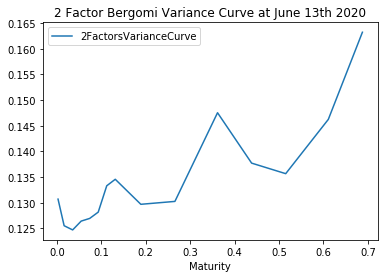

In [98]:
VarianceCurve = FuturePriceVIX[['Maturity','2FactorsVarianceCurve']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
VarianceCurve.plot(title = '2 Factor Bergomi Variance Curve at June 13th 2020')

De ce fait, à partir de la courbe de variance calculée, il est une nouvelle fois possible de valoriser les Futures VIX par Monte Carlo sous le modèle de Bergomi à deux facteurs pour ensuite les tracer:

In [99]:
T = FuturePriceVIX['Maturity']
TwoFactorssigma02 = FuturePriceVIX['2FactorsVarianceCurve']
n = len(FuturePriceVIX)

FuturePriceVIX["FVIX2FactorsBergomiPrice"] = [FVIXtwofactorsMC(T[i], TwoFactorssigma02[i],10000) for i in range(n)]
FuturePriceVIX.head()

,Expiration_Date,Symbol,Last,Change,High,Low,Settlement,Volume,Maturity,VarianceCurve,FVIXBergomiPrice,2FactorsVarianceCurve,FVIX2FactorsBergomiPrice
0,2020-06-12,VIX,0.3609,-4.70,0.4416,0.3497,0.36090,0,0.002740,0.130577,0.360907,0.130700,0.360883
1,2020-06-17,VXM20,0.3525,-5.38,0.4255,0.3495,0.35075,151177,0.016438,0.124858,0.350773,0.125520,0.350646
2,2020-06-24,VX25M20,0.4075,0.78,0.4075,0.3440,0.34625,30,0.035616,0.123666,0.346074,0.124704,0.346669
3,2020-07-01,VX26N20,0.3820,-1.83,0.4040,0.3445,0.34575,2,0.054795,0.125369,0.345811,0.126421,0.345680
4,2020-07-08,VX27N20,0.4090,0.80,0.4090,0.3455,0.34500,12,0.073973,0.126857,0.344830,0.126944,0.344443


Text(0.5, 1.0, 'Structure à terme des futures VIX le 13 Juin 2020')

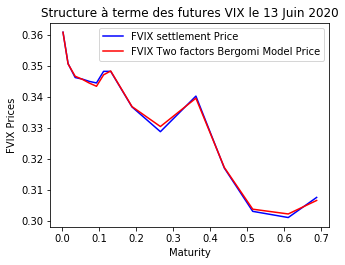

In [100]:
# On définit un dataframe contenant la volatilité implicite à deux facteurs des Puts en fonction du Strike en indice
term_structure = FuturePriceVIX[['Maturity','Settlement', 'FVIX2FactorsBergomiPrice']].sort_values('Maturity')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(term_structure['Maturity'],term_structure['Settlement'], color = 'b', label = 'FVIX settlement Price')
plt.plot(term_structure['Maturity'],term_structure['FVIX2FactorsBergomiPrice'], color = 'r', label = 'FVIX Two factors Bergomi Model Price')

plt.xlabel('Maturity')
plt.ylabel('FVIX Prices')
leg = ax.legend()
plt.title('Structure à terme des futures VIX le 13 Juin 2020')

Il est ainsi possible de constater qu'au vu de la similitude des prix du marché des Futures VIX et de ceux du modèle de Bergomi à deux facteurs que le calcul de la courbe de variance $\xi_0^T$ a été correctement effectué, témoignant ainsi de la bonne calibration de la variable. Avec ce calcul, il est donc possible de calculer la volatilité implicite des options vanilles sur VIX sous le modèle de Bergomi à deux facteurs.

## Calcul de la volatilité implicite sous le modèle à deux facteurs de Bergomi

Une fois de pluis, la volatilité implicite des options sur VIX selon le modèle de Bergomi à deux facteurs est la volatilité $\sigma_{imp}$ qui est telle que le prix des options calculé selon le modèle de Black Scholes avec comme paramètre spot le Future VIX soit égal à celui calculé par le modèle de Bergomi à deux facteurs. Ainsi, elle est définie telle que :
    
$$
P_{VIX,BS}(\sigma_{imp}^2,T,K) = P_{VIX,2FactorsBergomi}(T,K)
$$

Avec comme précédemment dans le cas des Calls et selon un taux d'intérêt nul :

$C_{VIX,BS}(\sigma^2,T,K)  = FVIX_0^T \mathcal{N}(d_1) - K\mathcal{N}(d_2)$ avec:

$d_1 = \frac{ln(FVIX_0^T/K)+\frac{\sigma^2}{2}T}{\sigma \sqrt{T}}$ et

$d_2 = d_1 - \sigma \sqrt{T}$

Cela équivaut à établir que $\sigma_{imp}$ est une racine de fonction telle que :

$$
\sigma_{imp} = root_\sigma (P_{VIX,BS}(\sigma^2,T,K) - P_{VIX,2FactorsBergomi}(T,K))
$$

Ici, la volatilité implicite sera calculée pour l'ensemble des Calls et Puts sur VIX dont la date d'expiration est le 16 Septembre 2020, quelque soit les Strikes.

Dans un premier temps, le prix des options sur VIX selon le modèle de Bergomi sera calculé pour chaque Strike sachant que la valeur de la courbe de variance $\sigma_0^2$ constante par morceau pour le modèle de bergomi à deux facteurs est égale à :

In [101]:
sigma02 = FuturePriceVIX[FuturePriceVIX['Expiration_Date']=='2020-09-16']['2FactorsVarianceCurve'].iloc[0]
print(sigma02)

0.13025655053587035


In [102]:
# Pricing Monte Carlo pour les Calls de maturité 3 mois
CallPriceVIX_3M = CallPriceVIX[CallPriceVIX['Expiration_Date']=='2020-09-16']
n = len(CallPriceVIX_3M)
CallPriceVIX_3M['index'] =[i for i in range (n)]
CallPriceVIX_3M = CallPriceVIX_3M.set_index('index')

sigma02 = FuturePriceVIX[FuturePriceVIX['Expiration_Date']=='2020-09-16']['2FactorsVarianceCurve'].iloc[0]
K = CallPriceVIX_3M["Strike"]
T = CallPriceVIX_3M["Maturity"]
TwoFactBergomi_Price =[0 for i in range(n)]
for i in range(n):
    TwoFactBergomi_Price[i] = VIXCallTwoFactorsBergomiMC(K[i],T[i], sigma02, 10000)

CallPriceVIX_3M['2Factors_Bergomi_Price'] = TwoFactBergomi_Price

# Pricing Monte Carlo pour les Puts de maturité de 3 mois
PutPriceVIX_3M = PutPriceVIX[PutPriceVIX['Expiration_Date']=='2020-09-16']
n = len(PutPriceVIX_3M)
PutPriceVIX_3M['index'] =[i for i in range (n)]
PutPriceVIX_3M = PutPriceVIX_3M.set_index('index')

K = PutPriceVIX_3M["Strike"]
T = PutPriceVIX_3M["Maturity"]
TwoFactBergomi_Price =[0 for i in range(n)]
for i in range(n):
    TwoFactBergomi_Price[i] = VIXPutTwoFactorsBergomiMC(K[i],T[i], sigma02, 10000)

PutPriceVIX_3M['2Factors_Bergomi_Price'] = Bergomi_Price

C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


les fonctions de calculs de la volatilité implicite sont une fois de plus modifiées et le calcul est effectué :

In [103]:
def all_implied_Vol_Call_2factors(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    BergomiPrice = data["2Factors_Bergomi_Price"]
    return float(FVIXImpliedVolCall(FVIX,K,T,BergomiPrice))

def all_implied_Vol_Put_2factors(data):
    FVIX = data['FVIX_Settlement_Price']
    K = data["Strike"]
    T = data["Maturity"]
    BergomiPrice = data["2Factors_Bergomi_Price"]
    return float(FVIXImpliedVolPut(FVIX,K,T,BergomiPrice))

In [104]:
CallPriceVIX_3M["Implied_Volatility_2factors"] = CallPriceVIX_3M.apply(all_implied_Vol_Call_2factors, axis = 1)
PutPriceVIX_3M["Implied_Volatility_2factors"] = PutPriceVIX_3M.apply(all_implied_Vol_Put_2factors, axis = 1)

### Traçage de la volatilité implicite sous le modèle de Bergomi à deux facteurs

Il est maintenant possible de tracer la volatilité implicite des Calls sur VIX  selon le modèle à deux facteurs en fonction du Strike.

Dans le cas du Smile de volatilité pour les Calls, avec une expiration égale au 16 Septembre 2020 c'est à dire une maturité de 3 mois, le code correspondant est le suivant:

Text(0.5, 1.0, 'Comparison IV of Calls, Maturity 3 months')

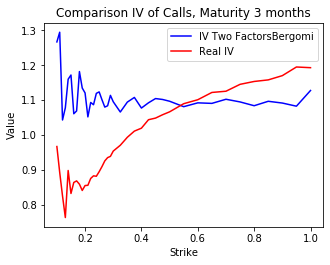

In [105]:
# On définit un dataframe contenant la volatilité implicite Bergomi des Calls en fonction du Strike en indice
iv_strike_bergomi = CallPriceVIX_3M[['Strike','Implied_Volatility_2factors']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite Réelle des Calls en fonction du Strike en indice
iv_strike_observed = CallPriceVIX_3M[['Strike','Implied_Volatility']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['Implied_Volatility_2factors'], color = 'b', label = 'IV Two FactorsBergomi')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['Implied_Volatility'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Calls, Maturity 3 months')

Et dans le cas des Puts : 

Text(0.5, 1.0, 'Comparison IV of Puts, Maturity 3 months')

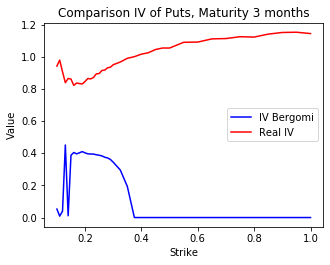

In [106]:
# On définit un dataframe contenant la volatilité implicite Bergomi des Puts en fonction du Strike en indice
iv_strike_bergomi = PutPriceVIX_3M[['Strike','Implied_Volatility_2factors']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite Réelle des Puts en fonction du Strike en indice
iv_strike_observed = PutPriceVIX_3M[['Strike','Implied_Volatility']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['Implied_Volatility_2factors'], color = 'b', label = 'IV Bergomi')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['Implied_Volatility'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Puts, Maturity 3 months')

Etant donné que les volatilités implicites du modèle de Bergomi à deux facteurs pour les Options de maturité 3 mois ne sont guères satisfaisantes visuellement, il convient de comparer graphiquement les prix de marché et du modèle de Bergomi à deux facteurs des Calls de maturité 3 mois pour différents Strikes.

Text(0.5, 1.0, 'Price comparison of Calls, Maturity 3 months')

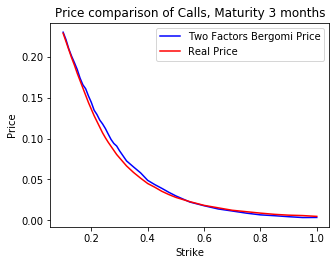

In [107]:
# On définit un dataframe contenant le prix Bergomi des Calls en fonction du Strike en indice
iv_strike_bergomi = CallPriceVIX_3M[['Strike','2Factors_Bergomi_Price']].sort_values('Strike')

# On définit un dataframe contenant le prix réel des Calls en fonction du Strike en indice
iv_strike_observed = CallPriceVIX_3M[['Strike','Mid']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_bergomi['Strike'],iv_strike_bergomi['2Factors_Bergomi_Price'], color = 'b', label = 'Two Factors Bergomi Price')
plt.plot(iv_strike_bergomi['Strike'],iv_strike_observed['Mid'], color = 'r', label = 'Real Price')
plt.xlabel('Strike')
plt.ylabel('Price')
leg = ax.legend()
plt.title('Price comparison of Calls, Maturity 3 months')

Ainsi, il est possible de constater que la courbe du prix en fonction du Strike sous le modèle de Bergomi à deux facteurs pour les Calls de maturité 3 mois est pratiquement ajustée à celle des prix Mid du marché, montrant ainsi des paramètres proches de ceux devant être obtenu après calibration, ainsi que l'efficacité du modèle quant à la précision de la valorisation. Ainsi, il convient de revoir l'algorithme de calcul de la volatilité implicite, ou de réduire la variance de l'estimation Monte Carlo pour le modèle de Bergomi.

## Calibration du modèle de Bergomi à deux facteurs

La calibration d'un tel modèle a été effectuée dans un autre projet traitant du pricing et de la calibration d'options sur S&P500 sous le modèle à volatilité stochastique log-normale de Bergomi.

# Bibliographie

- Lorenzo Bergomi, *Smile Dynamic II*, (2005)
- Fei Wang, *Forward Variance Dynamics: Bergomi Model And Its Applications In Pricing Cliquet Options*, Imperial College London (2017)
- J. Gatheral and  A. Jacquier, *Arbitrage-free SVI volatility surfaces*, Quantitative Finance, 14 (2014)
- B. Horvath, A. Jacquier, and P. Tankov, *Volatility options in rough volatility models*
- F.D. Rouah, *Variance Swap Pricing*